# Imports

In [1]:
import functions as fc
import json
import pandas as pd
import numpy as np
import sqlalchemy as db
import matplotlib.pyplot as plt
from sodapy import Socrata

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Query

In [2]:
# Load your PostgreSQL credential to `database_creds`
database_creds_file = open('./database_cred.json', 'r')
database_creds = json.loads(database_creds_file.read())

In [3]:
# Sign into your database
engine = db.create_engine(database_creds['url'])

connection = engine.connect()
metadata = db.MetaData()

In [4]:
sql = """
SELECT *
FROM ny_dhs_weekly
"""

weekly_df = pd.read_sql_query(sql, engine)

In [5]:
weekly_df.index = pd.to_datetime(weekly_df['date_of_census'])

In [6]:
weekly_df = weekly_df.drop('date_of_census', axis = 1)

In [18]:
weekly_df.head(2)

,total_adults_in_shelter,total_children_in_shelter,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
date_of_census,,,,,,,,,,,,
2019-12-01,38273,21709,59982,12128,4590,16719,12195,16308,21709,38017,2492,5245
2019-11-24,38490,21801,60292,12251,4613,16864,12230,16361,21801,38163,2499,5264


# Target EDA ( weekly_df )

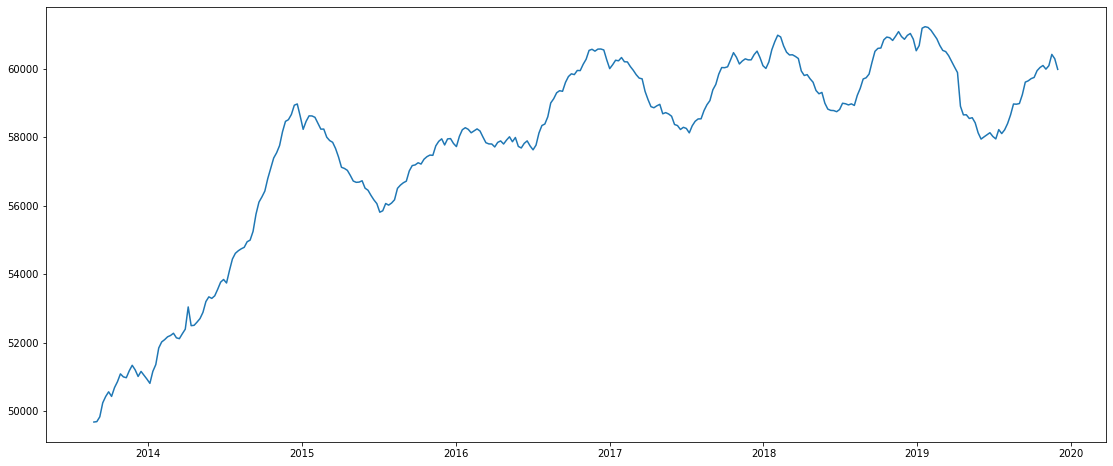

In [19]:
plt.figure(figsize = (19, 8))
plt.plot(weekly_df['total_individuals_in_shelter'], label = 'total') 

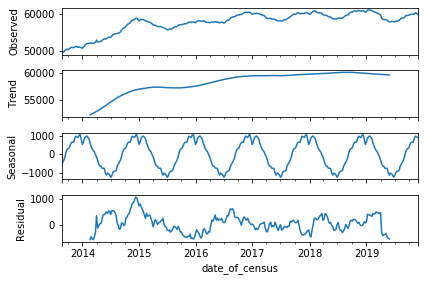

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'])
decomp.plot();

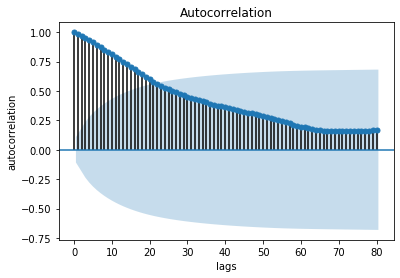

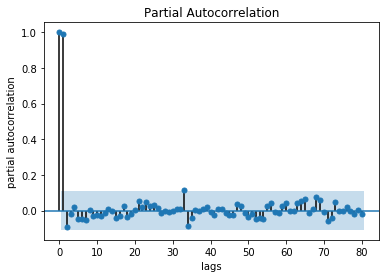

In [9]:
fc.acf_pacf(weekly_df['total_individuals_in_shelter'], 80)

The small lags values have large and positive correlations. This is a evidence of a trend.

look into war veteran data (more men)

The evidence of seasonailty observed in seasonal_decompose plot is not very evident in PACF plot.

# ARIMA Model

### Decide what 'order (p, d, q)' for the model
`p` (AR: AutoRegression)
- In the PACF plot, there is a sharp cut-off in lag 3.
- lag 1 value is positive.                  
--> p-value is a lag right before the cut-off. **p=1**

`d` (I: Integration)
- By differencing the data once, p-value went below 0.05, which indicates that the data is stationary. --> **d=1**

In [10]:
fc.adf(weekly_df['total_individuals_in_shelter'].dropna())

Test Statistic   -0.033033
p-value           0.955714
dtype: float64

In [12]:
fc.adf(weekly_df['total_individuals_in_shelter'].diff(1).dropna())

Test Statistic   -4.526301
p-value           0.000176
dtype: float64

`q` (MA: Moving Average)
- In ACF plot, no sharp cut-off was observed.
--> **q=0**

---

> `order = (1,1,0)` was selected.

In [20]:
test, train = train_test_split(weekly_df['total_individuals_in_shelter'],
                               test_size = 0.25,
                               shuffle = False)

In [25]:
# Instantiate model
model = ARIMA(endog = train.dropna(), # endog = Y variable
              order = (1, 1, 0), # (p, d, q) 
              freq = '-1W-SUN')
# Fit model
arima_1_1_0 = model.fit()

In [29]:
test

date_of_census
2019-12-01    59982
2019-11-24    60292
2019-11-17    60419
2019-11-10    60089
2019-11-03    59989
              ...  
2015-04-19    57031
2015-04-12    57087
2015-04-05    57121
2015-03-29    57420
2015-03-22    57668
Name: total_individuals_in_shelter, Length: 246, dtype: int64

In [31]:
test.index[-1]

Timestamp('2015-03-22 00:00:00')

In [33]:
# Generate prediction
preds_test = model.predict(params = arima_1_1_0.params,
                           start = test.index[-1],
                           end = test.index[0])

# preds_train = model.predict(params=arima_1_1_0.params,
#                             start=train.index[1], # Start at 1, instead of 0 becuase diff = 1
#                             end=train.index[-1])

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
resids_test = list(test.diff(1).dropna() - preds_test[1:])
resids_train = list(train.diff(1).dropna() - preds_train)

### Analysis
1. Predicted Weekly Difference 
2. Predicted Total Individuals in Shelter
---
- As diff = 1, the predictions are weekly difference, not the number of total individuals. I calculated the predicted number of total individuals from the predicted weekly difference.

#### 1. Predicted Weekly Difference

In [ ]:
plt.figure(figsize = (12,5))
plt.scatter(train.index[1:], resids_train)
plt.scatter(test.index[1:], resids_test)
plt.title('Residuals')
plt.axhline(0, color='red')

{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

In [ ]:
evaluate(test[1:], resids_test)

In [ ]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index[1:], train.diff(1).dropna().values, color = 'blue')

# Plot testing data.
plt.plot(test.index[1:], test.diff(1).dropna().values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(test.index, preds_test, color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting (diff = 1)', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### 2. Predicted Total Individuals in Shelter

In [ ]:
preds_test_index = [train.index[-1]] + list(test.index[1:])
preds_test_original_index = [train.index[-1]] + list(test.index)
preds_test_original = np.cumsum([train[-1]] + list(preds_test))
resids_test_original = list([train[-1]] + list(test) - preds_test_original)

In [ ]:
plt.figure(figsize = (12,5))
plt.scatter(train.index[1:], resids_train)
plt.scatter(preds_test_original_index, resids_test_original)
plt.title('Residuals')
plt.axhline(0, color='red')
{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

In [ ]:
evaluate(weekly_df.iloc[len(train.index)-1:,:], resids_test_original)

In [ ]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, train.values, color = 'blue')

# Plot testing data.
plt.plot(test.index, test.values, color = 'red', label = 'actual value')

# Plot predicted test values.
plt.plot(weekly_df.index[len(train.index)-1:], np.cumsum([train[-1]] + list(preds_test)), color = 'darkgreen', label = 'predited value')

# Set label.
plt.title(label = 'Forecasting', fontsize=24)
plt.legend(fontsize = 20)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

# SARIMA Model

- In seasonal_decompose plot, there seems to be seasonality. This was now indicated in PACF plot.
- However, when stationarity was achieved by differencing the data once, ACF and PACF curve indicate a sign of seasonality.
- Therefore, **Try SARIMA model**

### ACF, PACF plot (diff = 1)
- Shows a sign of seasonality

In [1]:
acf_pacf(weekly_df['total_individuals_in_shelter'].diff(1).dropna(), 100)

NameError: name 'acf_pacf' is not defined

### Seasonal Decompose plot (diff = 0)
- Shows a sign of seasonality

In [ ]:
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].dropna())
decomp.plot();

### Seasonal Decompose plot (diff = 1)
- Shows a sign of seasonality

In [ ]:
decomp = seasonal_decompose(weekly_df['total_individuals_in_shelter'].diff(1).dropna())
decomp.plot();

### Preliminary SARIMA
- There seems to be a seasonality every 52 weeks (1 year).
- Try `(P,D,Q,S)` = (0, 1, 0, 52)

In [ ]:
# Fit a SARIMA(0, 1, 0) x (0, 1, 0, 52) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (0, 1, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (1, 0, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [ ]:
preds_train = model.predict(start=train.index[0], # X_test data range
                            end=train.index[-1])

In [ ]:
resids_train = list(train - preds_train)

resids_test = list(test - preds)

In [ ]:
plt.figure(figsize = (12,5))
# plt.scatter(train.index[1:], resids_train[1:])
plt.scatter(test.index, resids_test)
plt.title('Residuals')
plt.axhline(0, color='red')

{"mean square error": sum(np.square(resids_test)) / len(resids_test)}

### Manual GridSearch
- Use grid search to find `seaonal_order`

In [ ]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,52,int(52/3)):
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 2, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

In [ ]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in [3, 4, 51, 52]: 
                # testing monthly seasonality with 3,4
                # testing yearly seaonailty with 51, 52
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Both gridsearch indicates that **SARIMAX(0, 2, 1)x(2,2,0,51)** minimizes MSE.

In [ ]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 51) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (2, 2, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [ ]:
resids = list(test - preds)

In [ ]:
evaluate(test, resids)